# Bloch Equations

Simple Bloch equations, no spatial stuff.

A major goal here is to make a continuously-drivable simulation, to simulate an actual experiment


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from pylab import *
from spylind import spyIVP as so
import sympy as sm;
sm.init_printing()

Tensorflow not accessible: No module named 'backend_tf'


In [2]:
B = sm.Matrix(sm.symbols('B_x, B_y, B_z'))
M = sm.Matrix(sm.symbols('M_x, M_y, M_z'))

T1, T2, Pz, Px = sm.symbols("T_1, T_2, P_z, P_x")

relax_terms = sm.Matrix([-M[0]/T2, -M[1]/T2, -(M[2]-0)/T1])
pump_term_z = sm.Matrix(
            [-M[0]*Pz/2, -M[1]*Pz/2, -(M[2]-1)*Pz]
        )
pump_term_x = sm.Matrix(
            [-(M[0]-1)*Px, -M[1]*Px/2, -M[2]*Px/2]
        )

In [3]:
dM_dt = M.cross(B) + relax_terms + pump_term_z + pump_term_x
display(dM_dt)

⎡                     Mₓ⋅P_z   Mₓ               ⎤
⎢-B_y⋅M_z + B_z⋅M_y - ────── - ── + Pₓ⋅(1 - Mₓ) ⎥
⎢                       2      T₂               ⎥
⎢                                               ⎥
⎢                     M_y⋅Pₓ   M_y⋅P_z   M_y    ⎥
⎢   Bₓ⋅M_z - B_z⋅Mₓ - ────── - ─────── - ───    ⎥
⎢                       2         2       T₂    ⎥
⎢                                               ⎥
⎢                   M_z⋅Pₓ   M_z                ⎥
⎢-Bₓ⋅M_y + B_y⋅Mₓ - ────── - ─── + P_z⋅(1 - M_z)⎥
⎣                     2       T₁                ⎦

In [4]:
from scipy import interpolate

In [5]:
import pdb

In [6]:
from scipy.interpolate import interp1d
class NoiseSequence:
    previous_values = None
    def __init__(self, sample_rate, t0 = 0, scale=1, block_size=100):
        self.dt = 1/sample_rate
        self.scale = scale
        self.block_size= block_size
        self.previous_values = []
        self.previous_t = []
        self.t_last_point = -self.dt
        self.generate_new_block()
        #self.previous_values = np.
    
    def generate_new_block(self):
        #print("generate new block")
        new_data =  self.scale*np.random.normal(size=self.block_size)
        new_t= np.arange(self.block_size)*self.dt + self.t_last_point +self.dt
        new_f = interp1d(np.hstack([self.previous_t, new_t]), np.hstack([self.previous_values, new_data]) )
        self._f = new_f 
        self.previous_values = new_data
        self.previous_t = new_t
        #pdb.set_trace()
        #print(f"old t_last{self.t_last_point}")
        self.t_last_point = new_t[-1]#self.block_size*self.dt
        #print(f"new t_last: {self.t_last_point}")
    
    def __call__(self, t):
        bGenNew = False
        if t >= self.t_last_point:
            self.generate_new_block()
            print(f"new t_last{self.t_last_point} because of request {t}")
            bGenNew = True
        try:
            val = self._f(t)
        except ValueError:
            print(f"requested t is {t}, t_last is {self.t_last_point}, and {bGenNew}")
            val =0
        return val
ns = NoiseSequence(10)
for t in linspace(0, 110, 50):
    print(t,ns(t))

0.0 -1.7556068834328213
2.2448979591836733 0.12413730820490548
4.489795918367347 0.10421107429337739
6.73469387755102 1.1308256911707668
8.979591836734693 0.7452924467215138
new t_last19.900000000000002 because of request 11.224489795918366
11.224489795918366 -0.6841066432151114
13.46938775510204 0.18855524738065207
15.714285714285714 1.3725058802929908
17.959183673469386 -0.37961677278531436
new t_last29.900000000000006 because of request 20.20408163265306
20.20408163265306 0.8325197810223192
22.448979591836732 -0.25048045973858973
24.693877551020407 -0.07553830938019825
26.93877551020408 -0.8430804880607607
29.183673469387752 -0.9100596448247561
new t_last39.900000000000006 because of request 31.428571428571427
31.428571428571427 0.1620541296440805
33.6734693877551 -0.1893425255296302
35.91836734693877 0.074918334221584
38.16326530612245 0.5691340425554539
new t_last49.900000000000006 because of request 40.40816326530612
40.40816326530612 0.09537144611436084
42.65306122448979 0.57423

In [7]:
d_dtD = dict(zip(M, dM_dt.subs({
            B[1]:0,
            B[2]:1,
            T2:20,
            T1: 10,
    }
)) )
ode_s = so.ODESolver(d_dtD,  dims={}, default_dtype = np.float64)
#ode_s.set_driving({B[0]: lambda t:  10 if (t<2 and t>1) else 0, B[2]:lambda t:0.2, Pr: lambda t: 100 if t%10 < 1  else 0})
B_noise = NoiseSequence(sample_rate = 10, block_size=100)
ode_s.set_driving({B[0]: lambda t:-.5+ B_noise(t) , Pz: lambda t: 100 if t%10 < 1  else 0, 
                   Px: lambda t: 1 if t%10 < 1  else 0})

ode_s.set_initial_conditions({M[0]:0, M[1]:0, M[2]:0}) 
model = ode_s.setup()


AttributeError: module 'spylind.spyIVP' has no attribute 'ODESolver'

Not integrating first step (it's just the initial state)
new t_last19.900000000000002 because of request 9.923865571361095
new t_last29.900000000000006 because of request 19.918712988112787
new t_last39.900000000000006 because of request 29.917692313390432
new t_last49.900000000000006 because of request 39.90405763206544
new t_last59.900000000000006 because of request 49.91325163099163
new t_last69.9 because of request 59.91006668473242
new t_last79.9 because of request 69.91708093459293
new t_last89.9 because of request 79.91158642033757
new t_last99.9 because of request 89.91570703523932
new t_last109.9 because of request 99.90108942566638


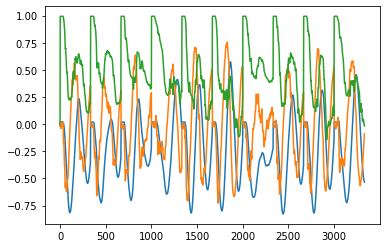

In [232]:
tSteps = linspace(0,10,1000)

arr = model.integrate_to(100, 0.03)
plot(arr)

In [140]:
res= model.continue_to(40, 0.03)
plot(res )

ValueError: Already integrated past 40 (tCur is 99.99

Not integrating first step (it's just the initial state)


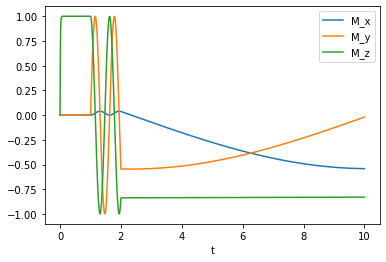

In [63]:
arr =ode_s.integrate(tSteps, 1.0)

#sm.ode
plot(tSteps, arr.real)
xlabel('t')
legend(d_dtD.keys())